In [72]:
import pandas as pd
from ase.visualize import view as view_molecule
from ase.io import read as read_molecule
import ase
import numpy as np
import random


from ase.cell import Cell
from dscribe.descriptors import CoulombMatrix, SineMatrix, EwaldSumMatrix, MBTR

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import numpy.linalg as LA
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [73]:
DATA_PATH = './nomad2018-predict-transparent-conductors'


In [74]:
train_data = pd.read_csv(
    f'{DATA_PATH}/train.csv')
train_data.head()


,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793


In [75]:
# # reg = LinearRegression().fit(train_data, train_data['formation_energy_ev_natom'])
# # reg.score(train_data,train_data['formation_energy_ev_natom'])
# train_data = pd.read_csv(
#     f'{DATA_PATH}/train.csv')
# train_data.head()

# labeldf = pd.DataFrame()
# labeldf["formation_energy_ev_natom"] = train_data['formation_energy_ev_natom']
# train_data = train_data.drop(['id',"formation_energy_ev_natom",'bandgap_energy_ev'],axis=1)
# # labeldf.head()
# X_train, X_test, y_train, y_test = train_test_split(train_data, labeldf, test_size = 0.30, random_state=1)
# lr_base = LinearRegression().fit(X_train, y_train)
# y_pred = lr_base.predict(X_test)
# print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# # print("Accuracy:", round((lr_base.score(X_test, y_pred)*100),2), "%")

In [76]:
test_data = pd.read_csv(
    f'{DATA_PATH}/test.csv')
test_data



,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree
0,1,33,80.0,0.1875,0.4688,0.3438,10.5381,9.0141,9.6361,89.9997,90.0003,90.0006
1,2,33,80.0,0.7500,0.2500,0.0000,9.8938,8.5014,9.1298,90.0038,90.0023,90.0015
2,3,167,30.0,0.6667,0.1667,0.1667,4.9811,4.9808,13.4799,89.9900,90.0109,120.0014
3,4,12,80.0,0.5625,0.4375,0.0000,24.3370,6.0091,5.7620,89.9995,103.8581,90.0002
4,5,12,80.0,0.1875,0.5000,0.3125,24.6443,6.2906,6.1589,90.0000,104.5929,90.0001
...,...,...,...,...,...,...,...,...,...,...,...,...
595,596,12,80.0,0.0000,0.5938,0.4062,24.8145,6.3964,6.2933,90.0002,104.7733,90.0001
596,597,33,40.0,0.1250,0.0000,0.8750,5.5783,9.4849,10.1107,90.0008,89.9967,90.0004
597,598,194,80.0,0.0000,0.2500,0.7500,6.9377,6.9372,25.0641,90.0072,89.9880,119.9857
598,599,33,40.0,0.6250,0.0000,0.3750,5.1841,8.8659,9.4956,90.0041,90.0009,90.0007


# Visualising the molecule

In [77]:
def get_xyz_data(filename):
    pos_data = []
    lat_data = []
    with open(filename) as f:
        for line in f.readlines():
            x = line.split()
            noise = np.array(
                [random.random()*0.001, random.random()*0.001, random.random()*0.001])
            if x[0] == 'atom':
                pos_data.append([np.array(x[1:4], dtype=float)+noise, x[4]])
            elif x[0] == 'lattice_vector':
                lat_data.append(np.array(x[1:4], dtype=float))
    return pos_data, np.array(lat_data)


xyzdata = get_xyz_data(f'{DATA_PATH}/train/10/geometry.xyz')
pos_data = xyzdata[0]
atoms = [ase.Atom(symbol=sym, position=pos) for pos, sym in pos_data]
mol = ase.Atoms(atoms)
# unlike jmol, the bonds are not automatically computed.
# hence, it does not look the same.
view_molecule(mol, viewer='x3d')


# Adding new features to the training data
- CoulombMatrix
- SineMatrix
- EwaldSumMatrix

In [78]:
np.array([1,2,3])+np.array([1,2,3])

array([2, 4, 6])

In [79]:
def get_xyz_data(filename):
    pos_data = []
    lat_data = []
    with open(filename) as f:
        for line in f.readlines():
            x = line.split()
            if x[0] == 'atom':
                pos_data.append([np.array(x[1:4], dtype=float), x[4]])
            elif x[0] == 'lattice_vector':
                lat_data.append(np.array(x[1:4], dtype=float))
    return pos_data, np.array(lat_data)


get_xyz_data(f'{DATA_PATH}/train/10/geometry.xyz')


([[array([-0.05487074, -0.02429496,  5.9479779 ]), 'Ga'],
  [array([-0.16461223, -0.07288488, 17.84393368]), 'Al'],
  [array([4.59925077, 2.74195764, 6.00133319]), 'Ga'],
  [array([ 4.48950929,  2.69336772, 17.89728898]), 'Ga'],
  [array([3.07074593, 0.01523894, 5.9770041 ]), 'Ga'],
  [array([ 2.96100444, -0.03335098, 17.87295989]), 'Ga'],
  [array([1.4736341 , 2.70242374, 5.97230698]), 'Ga'],
  [array([ 1.36389262,  2.65383382, 17.86826277]), 'Al'],
  [array([0., 0., 0.]), 'Ga'],
  [array([-0.10974148, -0.04858992, 11.89595579]), 'Ga'],
  [array([4.65412151, 2.7662526 , 0.05335529]), 'Ga'],
  [array([ 4.54438003,  2.71766268, 11.94931108]), 'Al'],
  [array([3.12561667, 0.0395339 , 0.0290262 ]), 'Ga'],
  [array([ 3.01587519e+00, -9.05602000e-03,  1.19249820e+01]), 'Al'],
  [array([1.52850484, 2.7267187 , 0.02432909]), 'Al'],
  [array([ 1.41876336,  2.67812878, 11.92028488]), 'Ga'],
  [array([-0.05030208,  1.79230656,  2.98053228]), 'Ga'],
  [array([-0.16004356,  1.74371664, 14.87648807

In [80]:
n_atoms_max = int(train_data['number_of_total_atoms'].max())
n_atoms_max

80

In [81]:
molecules = []
for idx in train_data['id']:
    path = f'{DATA_PATH}/train/{idx}/geometry.xyz'
    xyz_data = get_xyz_data(path)
    pos_data = xyz_data[0]
    lattice_vector_data = xyz_data[1]
    # create molecule
    atoms = [ase.Atom(symbol=sym, position=pos) for pos, sym in pos_data]
    mol = ase.Atoms(atoms)
    mol.set_cell(Cell(lattice_vector_data))
    molecules.append(mol)

In [82]:
coulomb_matrices = CoulombMatrix(
    n_atoms_max=n_atoms_max, 
    permutation="sorted_l2"
).create(molecules)


In [83]:
sine_matrices = SineMatrix(
    n_atoms_max=n_atoms_max, 
    permutation="sorted_l2",
).create(molecules, n_jobs=6)


In [84]:
ewald_sum_matrices = EwaldSumMatrix(
    n_atoms_max=n_atoms_max,
    permutation="sorted_l2"
).create(molecules, n_jobs=6)


In [85]:
sine_matrices.shape

(2400, 6400)

In [86]:
len(ewald_sum_matrices[0])

6400

In [87]:
len(coulomb_matrices)

2400

In [88]:
train_data

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev
0,1,33,80.0,0.6250,0.3750,0.0000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387
1,2,194,80.0,0.6250,0.3750,0.0000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210
2,3,227,40.0,0.8125,0.1875,0.0000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438
3,4,167,30.0,0.7500,0.0000,0.2500,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492
4,5,194,80.0,0.0000,0.6250,0.3750,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,2396,33,40.0,0.7500,0.2500,0.0000,4.9469,8.5014,9.1298,90.0038,90.0023,90.0015,0.0381,3.7349
2396,2397,167,30.0,0.4167,0.5833,0.0000,4.9566,4.9562,13.4178,89.9938,90.0075,120.0007,0.0670,3.4915
2397,2398,206,80.0,0.4375,0.5625,0.0000,9.2204,9.2200,9.2199,90.0047,90.0046,89.9954,0.0906,3.2750
2398,2399,33,80.0,0.3125,0.1875,0.5000,10.6529,9.0954,9.7210,90.0015,89.9996,90.0004,0.2566,1.3915


Baseline Model WITHOUT Matrices

converting to list before for writing purposes. If used directly, can assign `list(coulomb_matrices)` directly to the dataframe column.

In [89]:
train_data['CoulombMatrix'] = list(map(list, coulomb_matrices))
train_data['SineMatrix'] = list(map(list, sine_matrices))
train_data['EwaldSumMatrix'] = list(map(list, ewald_sum_matrices))


## Write data to a file and test i/o

In [90]:
train_data.to_csv(f'{DATA_PATH}/train_extrainfo.csv', index=False)

In [91]:
def custom_converter(entry):
    return np.array([float(x) for x in entry[1:-1].split(',')])

In [92]:
d = pd.read_csv(
    f'{DATA_PATH}/train_extrainfo.csv',
    converters={
        'CoulombMatrix':custom_converter,
        'SineMatrix':custom_converter,
        'EwaldSumMatrix':custom_converter
    }
)

In [93]:
d['CoulombMatrix'][0]

array([121.10109816,  75.93020649, 122.09373049, ...,   5.9815775 ,
         5.76657693,  22.9555197 ])

In [94]:
def get_eigenspectrum(matrix):
    spectrum = LA.eigvalsh(matrix)
    spectrum = np.sort(spectrum)[::-1]
    
    return spectrum

In [95]:
#eigen spectrum for COULOMB MATRIX

coulomb_spectrum_list = []

for i in range(len(molecules)):
    indv_coulomb_matrices = CoulombMatrix(
    n_atoms_max=n_atoms_max, 
    permutation="sorted_l2"
    ).create(molecules[i])

    indv_coulomb_matrices_reshaped = np.reshape(indv_coulomb_matrices, (80, 80))
    coulomb_spectrum = get_eigenspectrum(indv_coulomb_matrices_reshaped)
    
    coulomb_spectrum_list.append(coulomb_spectrum)


In [96]:
len(coulomb_spectrum_list)

2400

In [97]:
coulomb_spectrum_df = pd.DataFrame(coulomb_spectrum_list).astype(np.float)
coulomb_spectrum_df = coulomb_spectrum_df.fillna(0)

C:\Users\nishk\anaconda3\envs\ml_project\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


In [98]:
coulomb_spectrum_df.head()

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,5349.670575,2461.238885,2388.646992,1970.515905,1879.229060,1687.515631,1619.149902,690.312455,382.691651,281.769441,...,-254.250739,-279.496085,-341.163066,-1598.699411,-1719.355176,-1891.379647,-2039.259742,-2489.382511,-2597.659829,-2734.365505
1,4664.322585,2147.727882,1998.325524,1861.960977,1705.048052,1632.136799,1590.669761,1558.561418,1492.376760,654.182829,...,-413.818320,-1496.823919,-1544.634866,-1566.903258,-1623.816932,-1734.113741,-1806.289977,-1858.555690,-2138.252103,-2966.390007
2,2727.830716,1860.411298,1588.620741,552.747881,271.516366,236.203056,186.113271,173.590985,142.256288,131.995661,...,-88.026131,-103.703412,-113.934296,-191.318826,-210.035199,-226.004008,-294.823654,-1639.409806,-1862.883768,-2061.735274
3,7331.894032,5399.765457,4778.018158,514.965495,230.817922,167.771870,159.107466,114.975500,86.710914,71.134328,...,-56.373128,-66.902585,-77.627362,-83.466957,-109.657416,-186.131475,-199.580629,-277.410205,-5098.325108,-6106.648892
4,13920.567407,8054.780124,7661.623119,6149.728315,6011.462840,5412.362538,3381.764834,3010.433889,2539.909144,2055.048481,...,-1276.890588,-1885.138866,-2443.555876,-2766.815879,-3340.847398,-5148.200942,-5570.154756,-7562.172910,-8241.386034,-9085.907765


In [99]:
x = coulomb_spectrum_df.loc[:,:].values
y = train_data.loc[:,['formation_energy_ev_natom']].values
x = StandardScaler().fit_transform(x)

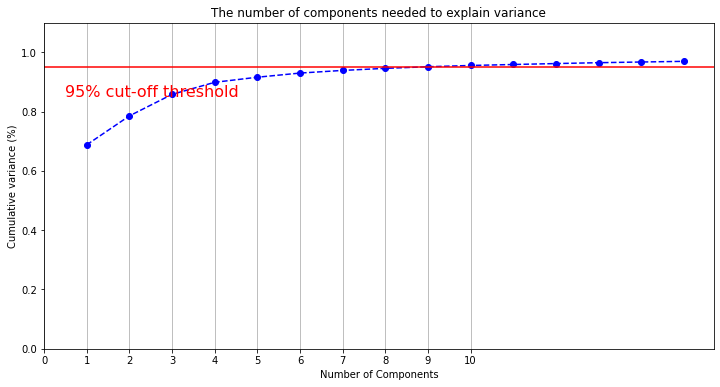

In [100]:
pca = PCA(n_components=15).fit(x)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 16, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [101]:
pca = PCA(n_components=80)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)

reg = LinearRegression().fit(principalDf, train_data['formation_energy_ev_natom'])
reg.score(principalDf,train_data['formation_energy_ev_natom'])

0.389801510131659

In [102]:
pca.explained_variance_ratio_

array([6.87970270e-01, 9.74630594e-02, 7.26111419e-02, 4.07060211e-02,
       1.71659541e-02, 1.40108603e-02, 8.93267124e-03, 6.93118444e-03,
       5.46383461e-03, 4.29817402e-03, 3.27485733e-03, 3.14512561e-03,
       2.93985365e-03, 2.31182514e-03, 2.24731515e-03, 2.12786882e-03,
       1.97080271e-03, 1.82286171e-03, 1.53073248e-03, 1.46571665e-03,
       1.41478997e-03, 1.23534146e-03, 1.17967055e-03, 1.07139854e-03,
       1.01919952e-03, 9.78013649e-04, 9.60926177e-04, 8.99746613e-04,
       7.96864276e-04, 7.65894775e-04, 7.38505982e-04, 6.76522244e-04,
       6.48423462e-04, 6.30270691e-04, 5.85757357e-04, 5.76168125e-04,
       5.22994012e-04, 4.89943777e-04, 4.62883905e-04, 4.42115356e-04,
       4.10201086e-04, 4.02504670e-04, 3.76676583e-04, 3.56992535e-04,
       3.46364001e-04, 3.16900430e-04, 3.01847435e-04, 2.85571052e-04,
       2.65840593e-04, 2.45786750e-04, 2.17656563e-04, 1.95524252e-04,
       1.85772135e-04, 1.64294650e-04, 1.52879392e-04, 1.31354866e-04,
      

In [103]:
dfcombined = pd.concat([train_data, principalDf], axis=1)
dfcombined2 = dfcombined.drop(['id','formation_energy_ev_natom','bandgap_energy_ev'],axis=1)
dfcombined2.head()

,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,...,70,71,72,73,74,75,76,77,78,79
0,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,...,-0.029337,-0.000452,-0.060755,0.068600,-0.126525,0.010712,0.021773,-0.027105,0.083012,-0.052632
1,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,...,0.083757,-0.022014,-0.006907,0.022460,-0.061425,0.108517,-0.038490,0.019382,-0.050802,0.018504
2,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,...,0.001861,-0.002909,0.000796,0.005115,-0.007152,-0.001725,-0.000029,0.001548,-0.002388,-0.003256
3,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,...,-0.002135,-0.005387,0.001092,0.005910,0.003812,-0.000118,0.001986,-0.004804,-0.002550,-0.004216
4,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,...,0.080642,-0.049259,0.042088,0.043522,-0.012883,0.050297,0.017245,-0.013954,-0.053056,0.007861


In [104]:
# reg = LinearRegression().fit(dfcombined2, train_data['formation_energy_ev_natom'])
# reg.score(dfcombined2,train_data['formation_energy_ev_natom'])

C:\Users\nishk\anaconda3\envs\ml_project\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


ValueError: setting an array element with a sequence.

In [ ]:
#eigen spectrum for SINE MATRIX

sine_spectrum_list = []

for i in range(len(molecules)):
    indv_sine_matrices = SineMatrix(
    n_atoms_max=n_atoms_max, 
    permutation="sorted_l2",
    ).create(molecules[i], n_jobs=6)

    indv_sine_matrices_reshaped = np.reshape(indv_sine_matrices, (80, 80))
    sine_spectrum = get_eigenspectrum(indv_sine_matrices_reshaped)
    
    sine_spectrum_list.append(sine_spectrum)

In [ ]:
sine_spectrum_df = pd.DataFrame(sine_spectrum_list).astype(np.float)
sine_spectrum_df = sine_spectrum_df.fillna(0)
sine_spectrum_df

ipykernel_launcher:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,3539.606021,2073.716418,1946.036827,1920.435148,1899.262776,1820.004110,1766.078494,1747.942999,1698.265091,1685.071450,...,46.292591,45.780665,45.320493,45.020839,43.894285,43.450853,43.100465,43.030871,42.395128,39.143104
1,3497.533557,2326.640420,2284.162022,1890.364073,1850.004911,1825.237091,1775.751992,1729.350296,1682.797435,1647.683463,...,22.753188,21.464056,19.544975,19.215818,17.345547,14.337988,10.984253,9.867467,9.761166,7.502202
2,2114.498907,1844.504676,1832.701657,510.639469,296.437256,271.128420,259.031140,247.896623,238.640763,228.355656,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,6414.563568,5559.482674,5207.148367,492.836449,303.154257,267.191219,203.112283,200.276372,194.416892,190.067712,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,9293.421443,6517.022988,6502.685580,5660.837218,5418.216587,5386.750372,5368.299819,5350.839172,5350.839164,5328.183064,...,30.982537,30.409295,30.390220,30.133569,26.413856,25.933955,19.488437,15.073036,15.072377,12.078421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,2408.655502,1858.103632,1779.754631,1732.230901,532.679988,295.616422,266.374699,249.891499,229.056911,227.919421,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2396,2924.555893,2056.358783,1898.224141,1682.363969,1660.641844,1628.968543,1603.827665,344.427255,254.010957,213.523545,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2397,4237.709432,2105.800829,2105.737014,1931.206898,1921.056882,1900.938991,1900.924191,1819.168344,1819.160965,1771.188713,...,46.051539,46.049366,40.786102,39.481437,39.480121,38.005612,37.676258,34.698258,34.697091,30.399366
2398,10194.331145,6089.975924,6034.992902,5804.263223,5712.493238,5555.780885,5487.971082,5418.180925,5382.400359,5348.841237,...,50.313206,50.034305,49.783089,49.402050,49.143630,48.582022,46.451592,45.931333,45.662316,43.500905


In [ ]:
x = sine_spectrum_df.loc[:,:].values
y = train_data.loc[:,['formation_energy_ev_natom']].values
x = StandardScaler().fit_transform(x)

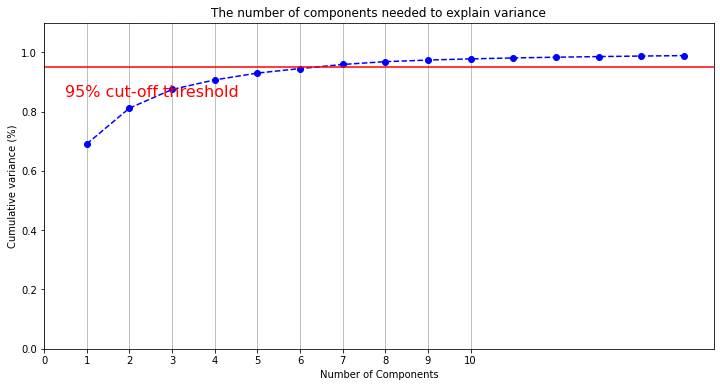

In [ ]:
pca = PCA(n_components=15).fit(x)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 16, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [ ]:
pca = PCA(n_components=80)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)

reg = LinearRegression().fit(principalDf, train_data['formation_energy_ev_natom'])
reg.score(principalDf,train_data['formation_energy_ev_natom'])

0.7246599928561226

In [ ]:
dfcombined = pd.concat([train_data, principalDf], axis=1)
dfcombined2 = dfcombined.drop(['id','formation_energy_ev_natom','bandgap_energy_ev'],axis=1)
dfcombined2.head()

,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,...,70,71,72,73,74,75,76,77,78,79
0,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,...,-0.003700,-0.002907,0.004438,0.001137,0.001608,-0.012608,0.002607,-0.000743,-0.001971,-0.004777
1,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,...,0.000900,0.010686,-0.014056,-0.007346,0.003003,0.008881,0.006281,-0.009465,-0.005478,-0.005299
2,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,...,-0.000182,-0.001170,-0.001962,0.000589,-0.000964,-0.000659,0.000600,0.000013,-0.000809,0.000060
3,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,...,-0.000245,0.000454,-0.000142,0.001563,0.000906,0.000429,0.000110,0.000496,-0.000037,0.000061
4,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,...,0.003742,-0.026200,0.005514,-0.000055,-0.007035,-0.003736,-0.003962,0.004179,-0.011264,0.004670


In [ ]:
reg = LinearRegression().fit(dfcombined2, train_data['formation_energy_ev_natom'])
reg.score(dfcombined2,train_data['formation_energy_ev_natom'])

/Users/simritajanakiraman/opt/anaconda3/envs/ml_project/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/simritajanakiraman/opt/anaconda3/envs/ml_project/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


0.8137277059775431

In [ ]:
#eigen spectrum for EWALD SUM MATRIX

ewald_spectrum_list = []

for i in range(len(molecules)):
    indv_ewald_matrices = EwaldSumMatrix(
    n_atoms_max=n_atoms_max, 
    permutation="sorted_l2",
    ).create(molecules[i], n_jobs=6)

    indv_ewald_matrices_reshaped = np.reshape(indv_ewald_matrices, (80, 80))
    ewald_spectrum = get_eigenspectrum(indv_ewald_matrices_reshaped)
    
    ewald_spectrum_list.append(ewald_spectrum)

In [ ]:
ewald_spectrum_df = pd.DataFrame(ewald_spectrum_list).astype(np.float)
ewald_spectrum_df = ewald_spectrum_df.fillna(0)
ewald_spectrum_df

ipykernel_launcher:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,459.572211,364.704069,295.205451,219.571880,208.766331,166.449031,66.719206,65.408416,55.399275,48.678502,...,-186.214720,-192.264956,-228.962156,-238.717015,-244.023073,-267.927011,-278.741454,-303.356993,-307.546466,-476.450750
1,3777.806938,3344.766610,589.356548,496.371385,105.150403,98.219701,20.296965,-10.533357,-10.805411,-11.177323,...,-307.395484,-325.091621,-372.119314,-399.911131,-424.755290,-465.096040,-477.996824,-478.952069,-487.131754,-667.531376
2,832.762436,669.912298,57.839067,49.539934,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-70.846980,-71.097729,-71.581234,-72.125587,-74.380757,-75.640609,-109.456096,-234.715876,-285.491451,-418.927026
3,1440.064967,733.151051,46.998168,38.744771,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-70.075593,-70.466186,-72.809680,-73.883759,-75.286318,-77.404511,-117.552051,-353.486578,-639.546683,-1084.506918
4,8983.912650,8983.474376,1670.623596,943.731659,146.533894,146.522038,16.552374,-8.164603,-8.209158,-8.214548,...,-561.596403,-1059.341082,-1060.893877,-1062.266189,-1063.459074,-1063.461428,-1065.022355,-1066.403602,-1067.611386,-1601.427763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,311.972378,196.797838,189.435192,144.368662,52.511461,39.119599,25.230035,12.980768,0.000000,0.000000,...,-63.775952,-65.267153,-66.034270,-66.152769,-67.393318,-93.337420,-173.887463,-219.434794,-287.229025,-407.401384
2396,1361.464977,1003.564967,55.962733,44.188077,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-73.737317,-75.171496,-85.636250,-156.529951,-196.503222,-281.874100,-371.327033,-398.051272,-437.221871,-647.142156
2397,425.910215,425.851317,303.334557,291.810908,276.377835,276.343502,76.986498,76.958747,56.709266,56.686167,...,-232.328740,-250.291989,-250.299072,-252.524880,-252.558152,-276.433068,-329.443671,-329.457122,-335.278875,-558.896661
2398,991.781390,778.459059,647.441972,404.111826,331.306743,253.883612,107.142493,86.997317,66.649259,58.204294,...,-465.939503,-500.554656,-527.918242,-581.692087,-592.663837,-673.256461,-686.042816,-705.287119,-728.866662,-1268.052026


In [ ]:
x = ewald_spectrum_df.loc[:,:].values
y = train_data.loc[:,['formation_energy_ev_natom']].values
x = StandardScaler().fit_transform(x)

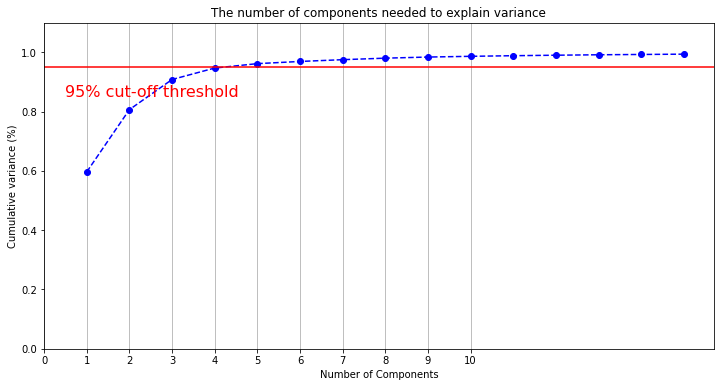

In [ ]:
pca = PCA(n_components=15).fit(x)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 16, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [ ]:
pca = PCA(n_components=80)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)

reg = LinearRegression().fit(principalDf, train_data['formation_energy_ev_natom'])
reg.score(principalDf,train_data['formation_energy_ev_natom'])

0.7793712684238527

In [ ]:
dfcombined = pd.concat([train_data, principalDf], axis=1)
dfcombined2 = dfcombined.drop(['id','formation_energy_ev_natom','bandgap_energy_ev'],axis=1)
dfcombined2.head()

,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,...,70,71,72,73,74,75,76,77,78,79
0,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,...,0.001421,-0.001074,0.000751,-0.004259,0.000712,0.000681,-0.001414,0.000850,-0.001472,-0.000156
1,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,...,0.003721,-0.005334,-0.006674,0.000329,0.005847,0.000448,-0.003898,0.000041,0.001687,0.000426
2,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,...,0.001140,-0.000078,0.000049,-0.000185,0.000092,-0.000034,0.000150,-0.000010,0.000093,-0.000002
3,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,...,0.000042,-0.000050,-0.000395,-0.000112,-0.000316,-0.000187,0.000081,0.000105,0.000198,-0.000156
4,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,...,0.004400,-0.000549,-0.000123,0.002322,0.002275,0.003178,0.000094,-0.001723,0.000096,0.000035


In [ ]:
reg = LinearRegression().fit(dfcombined2, train_data['formation_energy_ev_natom'])
reg.score(dfcombined2,train_data['formation_energy_ev_natom'])

/Users/simritajanakiraman/opt/anaconda3/envs/ml_project/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/simritajanakiraman/opt/anaconda3/envs/ml_project/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


0.8183328749251502

In [ ]:
x_c = coulomb_spectrum_df.loc[:,:].values
y = train_data.loc[:,['formation_energy_ev_natom']].values
x_c = StandardScaler().fit_transform(x_c)

x_s = sine_spectrum_df.loc[:,:].values
x_s = StandardScaler().fit_transform(x_s)

x_e = ewald_spectrum_df.loc[:,:].values
x_e = StandardScaler().fit_transform(x_e)

In [ ]:
pca_c = PCA(n_components=9).fit(x_c) #9
pca_s = PCA(n_components=7).fit(x_s) #7
pca_e = PCA(n_components=5).fit(x_e) #5

In [ ]:
principalComponents_c = pca_c.fit_transform(x_c)
principalDf_c = pd.DataFrame(data = principalComponents_c)

principalComponents_s = pca_c.fit_transform(x_s)
principalDf_s = pd.DataFrame(data = principalComponents_s)

principalComponents_e = pca_c.fit_transform(x_e)
principalDf_e = pd.DataFrame(data = principalComponents_e)

dfcombined_c = pd.concat([train_data, principalDf_c], axis=1)
dfcombined2_c = dfcombined_c.drop(['id','formation_energy_ev_natom','bandgap_energy_ev'],axis=1)
dfcombined2_c.head()

dfcombined_s = pd.concat([train_data, principalDf_s], axis=1)
dfcombined2_s = dfcombined_s.drop(['id','formation_energy_ev_natom','bandgap_energy_ev'],axis=1)
dfcombined2_s.head()

dfcombined_e = pd.concat([train_data, principalDf_e], axis=1)
dfcombined2_e = dfcombined_e.drop(['id','formation_energy_ev_natom','bandgap_energy_ev'],axis=1)
dfcombined2_e.head()

,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,0,1,2,3,4,5,6,7,8
0,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,-0.217935,4.888345,-3.453717,0.572505,0.253309,-0.661961,0.907501,-0.437272,-0.211124
1,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,4.798196,-3.904122,-6.654930,1.365515,-0.103370,-0.707233,-0.824026,0.780430,-0.775311
2,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,-8.020484,-0.910157,-0.341258,2.150770,1.113640,-0.644414,0.199551,0.237722,0.715789
3,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,-8.518402,-1.323789,0.469936,1.179540,0.403704,0.448864,-0.388646,-0.270016,-0.149327
4,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,13.234314,-5.291135,3.091594,4.021081,-2.912328,-1.215280,0.801213,-0.299725,-1.334996


In [ ]:
reg_c = LinearRegression().fit(principalDf_c, train_data['formation_energy_ev_natom'])
print("Score for Coulomb + LinReg: ", reg_c.score(principalDf_c,train_data['formation_energy_ev_natom']))

reg_s = LinearRegression().fit(principalDf_s, train_data['formation_energy_ev_natom'])
print("Score for Sine + LinReg: ", reg_s.score(principalDf_s,train_data['formation_energy_ev_natom']))

reg_e = LinearRegression().fit(principalDf_e, train_data['formation_energy_ev_natom'])
print("Score for Ewald + LinReg: ", reg_e.score(principalDf_e,train_data['formation_energy_ev_natom']))

Score for Coulomb + LinReg:  0.2736080390803125
Score for Sine + LinReg:  0.47327849775638564
Score for Ewald + LinReg:  0.3794169592113873


In [ ]:
ridge_reg_c = Ridge(alpha=0.001).fit(principalDf_c, train_data['formation_energy_ev_natom'])
print("Score for Coulomb + Ridge Reg: ", ridge_reg_c.score(principalDf_c,train_data['formation_energy_ev_natom']))

ridge_reg_s = Ridge(alpha=0.001).fit(principalDf_s, train_data['formation_energy_ev_natom'])
print("Score for Sine + Ridge Reg: ", ridge_reg_s.score(principalDf_s,train_data['formation_energy_ev_natom']))

ridge_reg_e = Ridge(alpha=0.001).fit(principalDf_e, train_data['formation_energy_ev_natom'])
print("Score for Ewald + Ridge Reg: ", ridge_reg_e.score(principalDf_e,train_data['formation_energy_ev_natom']))

Score for Coulomb + Ridge Reg:  0.2736080390802894
Score for Sine + Ridge Reg:  0.47327849775633424
Score for Ewald + Ridge Reg:  0.37941695921124574


In [ ]:
lasso_reg_c = Lasso(alpha=0.001, max_iter=1e5).fit(principalDf_c, train_data['formation_energy_ev_natom'])
print("Score for Coulomb + Lasso Reg: ", lasso_reg_c.score(principalDf_c,train_data['formation_energy_ev_natom']))

lasso_reg_s = Lasso(alpha=0.001, max_iter=1e5).fit(principalDf_s, train_data['formation_energy_ev_natom'])
print("Score for Sine + Lasso Reg: ", lasso_reg_s.score(principalDf_s,train_data['formation_energy_ev_natom']))

lasso_reg_e = Lasso(alpha=0.001, max_iter=1e5).fit(principalDf_e, train_data['formation_energy_ev_natom'])
print("Score for Ewald + Lasso Reg: ", lasso_reg_e.score(principalDf_e,train_data['formation_energy_ev_natom']))

Score for Coulomb + Lasso Reg:  0.27294291315043695
Score for Sine + Lasso Reg:  0.4726680098162742
Score for Ewald + Lasso Reg:  0.37840704631839417


In [ ]:
rf_c = RandomForestRegressor(n_estimators=1000, random_state=2).fit(principalDf_c, train_data['formation_energy_ev_natom'])
print("Score for Coulomb + RF Reg: ", rf_c.score(principalDf_c,train_data['formation_energy_ev_natom']))

rf_s = RandomForestRegressor(n_estimators=1000, random_state=2).fit(principalDf_s, train_data['formation_energy_ev_natom'])
print("Score for Sine + RF Reg: ", rf_s.score(principalDf_s,train_data['formation_energy_ev_natom']))

rf_e = RandomForestRegressor(n_estimators=1000, random_state=2).fit(principalDf_e, train_data['formation_energy_ev_natom'])
print("Score for Ewald + RF Reg: ", rf_e.score(principalDf_e,train_data['formation_energy_ev_natom']))


Score for Coulomb + RF Reg:  0.9219629173011572
Score for Sine + RF Reg:  0.9699765581906306
Score for Ewald + RF Reg:  0.9716140210512212


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(principalDf_c, train_data['formation_energy_ev_natom'], test_size = 0.30, random_state=1)
rf_c2 = RandomForestRegressor(n_estimators=1000, random_state=2).fit(X_train, y_train)
y_pred = rf_c2.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("Accuracy:", round((rf_c2.score(X_test, y_pred)*100),2), "%")

Accuracy: 100.0 %


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(principalDf_s, train_data['formation_energy_ev_natom'], test_size = 0.30, random_state=1)
rf_c2 = RandomForestRegressor(n_estimators=1000, random_state=2).fit(X_train, y_train)
y_pred = rf_c2.predict(X_test)
print("Accuracy:", round((rf_c2.score(X_test, y_pred)*100),2), "%")

Accuracy: 100.0 %


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(principalDf_e, train_data['formation_energy_ev_natom'], test_size = 0.30, random_state=1)
rf_c2 = RandomForestRegressor(n_estimators=1000, random_state=2).fit(X_train, y_train)
y_pred = rf_c2.predict(X_test)
print("Accuracy:", ((rf_c2.score(X_test, y_pred)*100)), "%")

Accuracy: 100.0 %
